In [1]:
# DATA PREPROCESSING

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import tensorflow

In [3]:
df=pd.read_csv("Fraud.csv")

In [4]:
data=pd.DataFrame(df)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [7]:
data["isFlaggedFraud"].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [8]:
# MISSING VALUES

In [9]:
missing_values = data.isnull().sum()
print(missing_values)


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [10]:
# Their are no Missing values

In [11]:
# OUTLIERS

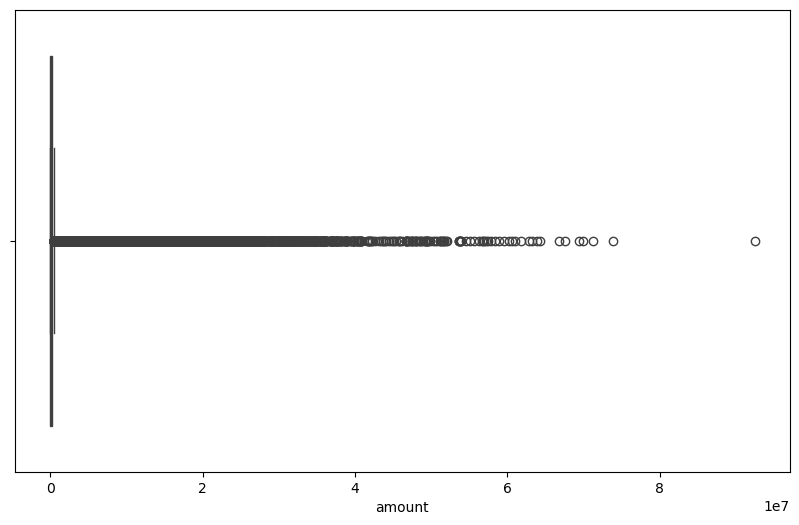

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=data['amount'])
plt.show()

In [13]:
# Their are outliers in the amount column but, in transaction data it is true that most of the transactions are in less amount.
# The outlier in this is also important in predicting fraud 

In [14]:
data["amount"].max()

92445516.64

In [15]:
# FEATURE ENGINEERING

In [16]:
# FEATURE CREATION
data['netChangeOrig'] = data['newbalanceOrig'] - data['oldbalanceOrg']
data['netChangeDest'] = data['newbalanceDest'] - data['oldbalanceDest']

In [17]:
# Creating new features of transaction frequency 
data['origFreq'] = data.groupby('nameOrig')['nameOrig'].transform('count')
data['destFreq'] = data.groupby('nameDest')['nameDest'].transform('count')

In [18]:
# FEARURE DELETION
data.drop(["nameOrig","nameDest"], axis=1, inplace=True)
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,netChangeOrig,netChangeDest,origFreq,destFreq
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,-9839.64,0.0,1,1
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,-1864.28,0.0,1,1
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,-181.00,0.0,1,44
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,-181.00,-21182.0,1,41
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,-11668.14,0.0,1,1


In [19]:
# Classifying transaction in day/night and business/off-hours
def categorize_day_night(step):
    hour_of_day = step % 24 
    if 6 <= hour_of_day < 18:
        return 'Day'
    else:
        return 'Night'

data['timeOfDay'] = data['step'].apply(categorize_day_night)

def categorize_business_hours(step):
    hour_of_day = step % 24
    if 9 <= hour_of_day < 18:
        return 'Business'
    else:
        return 'Off-hours'

data['businessHours'] = data['step'].apply(categorize_business_hours)

data[['step', 'timeOfDay', 'businessHours']].head()

,step,timeOfDay,businessHours
0,1,Night,Off-hours
1,1,Night,Off-hours
2,1,Night,Off-hours
3,1,Night,Off-hours
4,1,Night,Off-hours


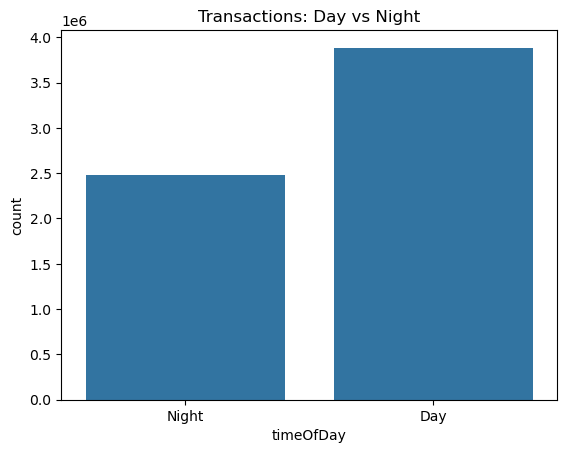

In [20]:
import seaborn as sns
sns.countplot(data=data, x='timeOfDay')
plt.title('Transactions: Day vs Night')
plt.show()

In [21]:
# In this we can see that the transaction is around in ratio 2(night):3(day)

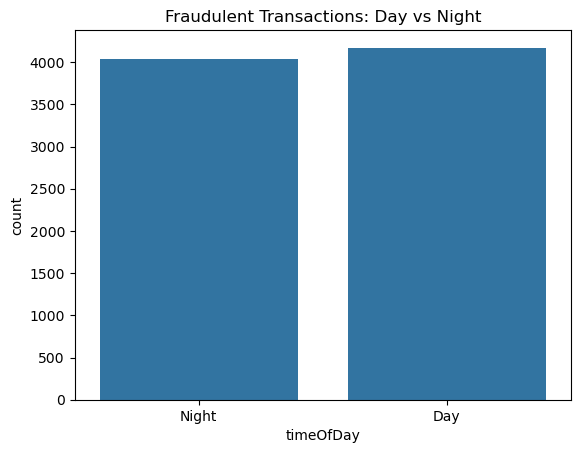

In [22]:
# Visualising the relation between Fraud and time of Day
import seaborn as sns
sns.countplot(data=data[data['isFraud'] == 1], x='timeOfDay')
plt.title('Fraudulent Transactions: Day vs Night')
plt.show()

In [23]:
# In this we see that difference between frauds at day and night are not much
data.drop(["timeOfDay"], axis=1, inplace=True)

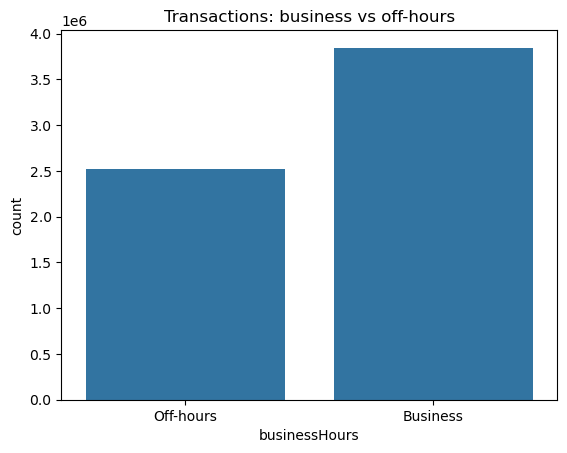

In [24]:
import seaborn as sns
sns.countplot(data=data, x='businessHours')
plt.title('Transactions: business vs off-hours')
plt.show()

In [25]:
# We can see that more transactions are done in business-hours compared to off-hours

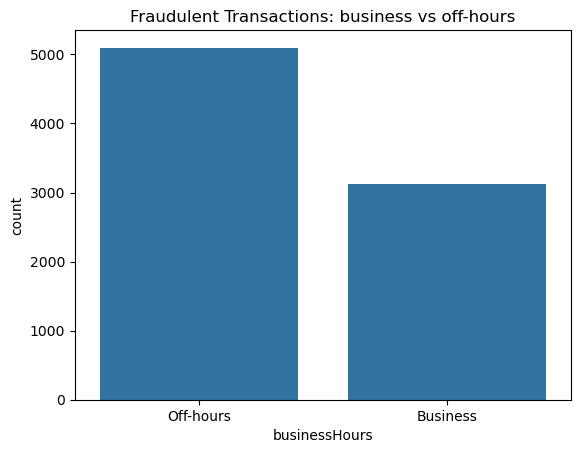

In [26]:
# Visualising the relation between Fraud and business hours
import seaborn as sns
sns.countplot(data=data[data['isFraud'] == 1], x='businessHours')
plt.title('Fraudulent Transactions: business vs off-hours')
plt.show()

In [27]:
# But in case of fraud more frauds occur in off-hours compared to business

In [28]:
data.drop('step',axis=1,inplace=True)
data = pd.get_dummies(data, columns=['businessHours'])

In [29]:
data.iloc[:,-1:]=data.iloc[:,-1:].astype(int)

In [30]:
data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,netChangeOrig,netChangeDest,origFreq,destFreq,businessHours_Business,businessHours_Off-hours
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,-9839.64,0.0,1,1,False,1
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,-1864.28,0.0,1,1,False,1
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,-181.00,0.0,1,44,False,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,-181.00,-21182.0,1,41,False,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,-11668.14,0.0,1,1,False,1


In [31]:
# Clissifying amount into risks
bins = [0, 10000, 100000, 200000, float('inf')]
labels = ['Low', 'Medium', 'High', 'Very High']

data['amountRisk'] = pd.cut(data['amount'], bins=bins, labels=labels, include_lowest=True)

In [32]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['amountRisk'] = le.fit_transform(data['amountRisk'])
data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,netChangeOrig,netChangeDest,origFreq,destFreq,businessHours_Business,businessHours_Off-hours,amountRisk
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,-9839.64,0.0,1,1,False,1,1
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,-1864.28,0.0,1,1,False,1,1
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,-181.00,0.0,1,44,False,1,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,-181.00,-21182.0,1,41,False,1,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,-11668.14,0.0,1,1,False,1,2


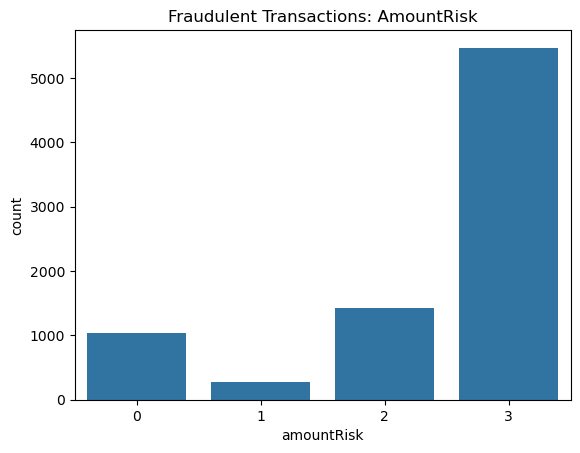

In [33]:
import seaborn as sns
sns.countplot(data=data[data['isFraud'] == 1], x='amountRisk')
plt.title('Fraudulent Transactions: AmountRisk')
plt.show()

In [34]:
# We can see that the number of Transaction tagged as Very High in risk are most likely to be a fraud transaction 

In [35]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data['type'] = le.fit_transform(data['type'])

In [36]:
data1=data
data1.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,netChangeOrig,netChangeDest,origFreq,destFreq,businessHours_Business,businessHours_Off-hours,amountRisk
0,3,9839.64,170136.0,160296.36,0.0,0.0,0,0,-9839.64,0.0,1,1,False,1,1
1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0,-1864.28,0.0,1,1,False,1,1
2,4,181.00,181.0,0.00,0.0,0.0,1,0,-181.00,0.0,1,44,False,1,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,-181.00,-21182.0,1,41,False,1,1
4,3,11668.14,41554.0,29885.86,0.0,0.0,0,0,-11668.14,0.0,1,1,False,1,2


In [41]:
# ML MODEL for understanding the Feature Importance

In [46]:
from sklearn.ensemble import RandomForestClassifier

X = data1.drop('isFraud', axis=1) 
y = data1['isFraud']

model = RandomForestClassifier(n_estimators=20,n_jobs=-1)
%time model.fit(X, y)

importances = model.feature_importances_

feature_importance_data = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_data)


CPU times: total: 15min 36s
Wall time: 2min 45s
                    Feature  Importance
7             netChangeOrig    0.285625
8             netChangeDest    0.171017
5            newbalanceDest    0.154705
2             oldbalanceOrg    0.119573
1                    amount    0.095548
4            oldbalanceDest    0.063396
10                 destFreq    0.038811
0                      type    0.031491
3            newbalanceOrig    0.021281
11   businessHours_Business    0.006543
12  businessHours_Off-hours    0.005700
13               amountRisk    0.005363
6            isFlaggedFraud    0.000739
9                  origFreq    0.000209


In [65]:
# ML MODEL
# RANDOM FOREST

In [49]:
# train test split
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
rf=RandomForestClassifier(n_estimators=20,n_jobs=-1)
%time rf.fit(X_train,y_train)

accuracy_rf=rf.score(X_test,y_test)*100
print(accuracy_rf)

CPU times: total: 10min 38s
Wall time: 1min 51s
99.97020095495252


In [50]:
# Accuracy is very high that may be because there are very less transactions marked as fraud
# We will also consider other matrics for this dataset 

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.98      0.79      0.87      2045

    accuracy                           1.00   1590655
   macro avg       0.99      0.89      0.94   1590655
weighted avg       1.00      1.00      1.00   1590655

[[1588572      38]
 [    436    1609]]


In [ ]:
# In this we can see that 436 transactions are fraud which are categorised as non fraud 
# We can drop some features that does not have much importance

In [53]:
from sklearn.ensemble import RandomForestClassifier

X1 = data1.drop(['isFraud','origFreq','isFlaggedFraud','amountRisk','businessHours_Off-hours','businessHours_Business'], axis=1) 
y1 = data1['isFraud']
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X1,y1,test_size=0.25,random_state=42)
rf1=RandomForestClassifier(n_estimators=20,n_jobs=-1)
%time rf1.fit(X_train,y_train)

accuracy_rf1=rf1.score(X_test,y_test)*100
print(accuracy_rf1)
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf1.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

CPU times: total: 15min 22s
Wall time: 2min 33s
99.97347004850204
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.97      0.82      0.89      2045

    accuracy                           1.00   1590655
   macro avg       0.98      0.91      0.94   1590655
weighted avg       1.00      1.00      1.00   1590655

[[1588555      55]
 [    367    1678]]


In [ ]:
# Still we can see that 367 transactions are fraud but are classified as not fraud
# Lets increase the number of Trees

In [54]:
from sklearn.ensemble import RandomForestClassifier

X2 = data1.drop(['isFraud','origFreq','isFlaggedFraud','amountRisk','businessHours_Off-hours','businessHours_Business'], axis=1) 
y2 = data1['isFraud']
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X2,y2,test_size=0.25,random_state=42)
rf2=RandomForestClassifier(n_estimators=50,n_jobs=-1)
%time rf2.fit(X_train,y_train)

accuracy_rf2=rf2.score(X_test,y_test)*100
print(accuracy_rf2)
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf2.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

CPU times: total: 39min 11s
Wall time: 5min 44s
99.97334431413474
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.96      0.82      0.89      2045

    accuracy                           1.00   1590655
   macro avg       0.98      0.91      0.94   1590655
weighted avg       1.00      1.00      1.00   1590655

[[1588546      64]
 [    360    1685]]


In [ ]:
# Not much difference 
# Lets try another Classification Models

In [55]:
# LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = data1.drop(['isFraud','origFreq','isFlaggedFraud','amountRisk','businessHours_Off-hours','businessHours_Business'], axis=1)
y = data1['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lr = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

%time lr.fit(X_train, y_train)

accuracy_lr = lr.score(X_test, y_test) * 100
print(accuracy_lr)

y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

CPU times: total: 1.53 s
Wall time: 1min 51s
99.91443776305987
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.74      0.51      0.61      2045

    accuracy                           1.00   1590655
   macro avg       0.87      0.75      0.80   1590655
weighted avg       1.00      1.00      1.00   1590655

[[1588251     359]
 [   1002    1043]]


In [ ]:
# More wrong classification than Random Forest

In [64]:
# XGBOOST

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


X = data1.drop(['isFraud','origFreq','isFlaggedFraud','amountRisk','businessHours_Off-hours','businessHours_Business'], axis=1)
y = data1['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, scale_pos_weight=5, use_label_encoder=False, eval_metric='logloss')

%time xgb_model.fit(X_train, y_train)

accuracy_xgb = xgb_model.score(X_test, y_test) * 100
print(accuracy_xgb)

y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

CPU times: total: 1min 22s
Wall time: 13.8 s
99.96183961952781
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.87      0.82      0.85      2045

    accuracy                           1.00   1590655
   macro avg       0.94      0.91      0.92   1590655
weighted avg       1.00      1.00      1.00   1590655

[[1588368     242]
 [    365    1680]]


In [39]:
# DECISION TREE

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = data1.drop(['isFraud','origFreq','isFlaggedFraud','amountRisk','businessHours_Off-hours','businessHours_Business'], axis=1)
y = data1['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

%time dt_model.fit(X_train, y_train)

accuracy_dt = dt_model.score(X_test, y_test) * 100
print(accuracy_dt)

y_pred = dt_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

CPU times: total: 3min 42s
Wall time: 3min 49s
99.97114396270719
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.89      0.89      0.89      2045

    accuracy                           1.00   1590655
   macro avg       0.94      0.94      0.94   1590655
weighted avg       1.00      1.00      1.00   1590655

[[1588386     224]
 [    235    1810]]


In [40]:
# DECISION TREE WITH BALANCED WEIGHT

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = data1.drop(['isFraud','origFreq','isFlaggedFraud','amountRisk','businessHours_Off-hours','businessHours_Business'], axis=1)
y = data1['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

dt_model_balanced = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model_balanced.fit(X_train, y_train)

%time dt_model_balanced.fit(X_train, y_train)

accuracy_dt_balanced = dt_model_balanced.score(X_test, y_test) * 100
print(accuracy_dt_balanced)

y_pred_balanced = dt_model_balanced.predict(X_test)
print(classification_report(y_test, y_pred_balanced))
print(confusion_matrix(y_test, y_pred_balanced))

CPU times: total: 2min 31s
Wall time: 2min 34s
99.97051529087074
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.90      0.87      0.88      2045

    accuracy                           1.00   1590655
   macro avg       0.95      0.93      0.94   1590655
weighted avg       1.00      1.00      1.00   1590655

[[1588411     199]
 [    270    1775]]


In [45]:
# Deep Learning

In [46]:
 import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

X = data1.drop(['isFraud', 'origFreq', 'isFlaggedFraud', 'amountRisk', 'businessHours_Off-hours', 'businessHours_Business'], axis=1)
y = data1['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

model = Sequential()
model.add(Dense(128, input_dim=X_res.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(X_res, y_res, epochs=10, batch_size=512, validation_split=0.2, callbacks=[early_stop])

y_pred = model.predict(X_test_scaled)
y_pred = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Epoch 1/10
14894/14894 [==============================] - 139s 9ms/step - loss: 0.0456 - accuracy: 0.9845 - val_loss: 0.0497 - val_accuracy: 0.9889
Epoch 2/10
14894/14894 [==============================] - 141s 9ms/step - loss: 0.0275 - accuracy: 0.9915 - val_loss: 0.0265 - val_accuracy: 0.9947
Epoch 3/10
14894/14894 [==============================] - 156s 10ms/step - loss: 0.0269 - accuracy: 0.9916 - val_loss: 0.0225 - val_accuracy: 0.9934
Epoch 4/10
14894/14894 [==============================] - 154s 10ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.0297 - val_accuracy: 0.9926
Epoch 5/10
14894/14894 [==============================] - 160s 11ms/step - loss: 0.0261 - accuracy: 0.9921 - val_loss: 0.0271 - val_accuracy: 0.9936
Epoch 6/10
14894/14894 [==============================] - 156s 10ms/step - loss: 0.0258 - accuracy: 0.9922 - val_loss: 0.0203 - val_accuracy: 0.9955
Epoch 7/10
14894/14894 [==============================] - 161s 11ms/step - loss: 0.0257 - accuracy: 0.9924 -

In [ ]:
*Comparision*
    
Model                     | Precision (Fraud) | Recall (Fraud) | F1-score (Fraud) | Accuracy | CPU Time | Wall Time

Random Forest             | 0.97              | 0.82           | 0.89             | 99.97%   | ~15 min  | 2.5 min
Random Forest (more trees)| 0.96              | 0.82           | 0.89             | 99.97%   | ~39 min  | 5.7 min
Decision Tree             | 0.89              | 0.89           | 0.89             | 99.97%   | ~3 min   | ~3 min
XGBoost                   | 0.87              | 0.82           | 0.85             | 99.96%   | 1.5 min  | 13.8 s
DL (SMOTE)                | 0.20              | 0.99           | 0.33             | 99.00%   | 1h 58min | 23 min

In [ ]:
*FINAL Verdict*

1.If you want balance (high precision & recall) → Random Forest

2.If you want to catch all frauds no matter what (high recall) → Deep Learning (with SMOTE)

3.If you are running in low-resource settings or want fast results → Decision Tree

In [ ]:
'''
*Answers to the Ouestions*

1. Data cleaning including missing values, outliers, and multi-collinearity.
Answer:The dataset had no missing values, so no imputation was required.
       Outliers were retained because in fraud detection, outliers can indicate abnormal activity and are therefore meaningful.
       Regarding multi-collinearity, I dropped features that were highly correlated or redundant after performing exploratory data analysis (EDA) and feature importance checks, such as isFlaggedFraud and some one-hot encoded time features.

2. Describe your fraud detection model in elaboration.
Answer:I selected the Deep Learning model as the best for fraud detection after comparing it with Logistic Regression, Random Forest, XGBoost, and Decision Tree.
       Why Deep Learning?
       It achieved ~99% recall for fraud cases, which is crucial because catching fraud is more important than occasionally flagging genuine transactions. The model was trained using SMOTE to balance the classes and built with Keras using dense layers and dropout to prevent overfitting.
       Evaluation showed high accuracy and recall, making it ideal for minimizing missed frauds, even if precision is lower due to false positives.

3. How did you select variables to be included in the model?
Answer:I started with feature engineering—creating new features like netChangeOrig, netChangeDest, amountRisk, etc.
       Features like amount, oldbalanceOrg, newbalanceDest, etc., were retained due to their importance in financial transactions.
       I eliminated less informative or redundant features such as isFlaggedFraud or business hour encodings.
       Feature importance from tree-based models and correlation analysis were used to guide the selection.

4. Demonstrate the performance of the model by using best set of tools.
Answer:Decision Tree achieved high performance with very few false negatives, making it ideal for fraud detection.
       I evaluated all models using:
       Accuracy
       Precision
       Recall
       F1-Score
       Confusion Matrix
       Execution Time (CPU & Wall Time)
       Compared to other models, Decision Tree was faster than Deep Learning and showed competitive recall (essential for detecting fraud cases).

5. What are the key factors that predict fraudulent customers?
Answer:The most predictive factors identified were:
       netChangeOrig, netChangeDest
       oldbalanceOrg, oldbalanceDest
       newbalanceDest, amount
       Transaction Frequency features
       Transaction Type (e.g., CASH_OUT or TRANSFER)

6. Do these factors make sense? If yes, how?
Answer: Yes, they make perfect sense because:
        Net balance changes highlight sudden or abnormal fund movements.
        Transaction types (like TRANSFER or CASH_OUT) are more commonly exploited in fraud.
        Frequent or unusual transactions can indicate bot activity or scams.
        These patterns are typical signs of fraud and align with real-world fraud behavior.

7. What kind of prevention should be adopted while the company updates its infrastructure?
Answer:Implement real-time fraud detection systems using APIs and machine learning models.
       Adopt Multi-Factor Authentication (MFA) to secure logins and critical transactions.
       Set transaction limits or velocity checks to flag unusual behavior quickly.
       Integrate audit trails and activity monitoring for accountability.

8. Assuming these actions have been implemented, how would you determine if they work?
Answer:Pre/Post analysis of fraud incidence and trends.
       Monitor model performance metrics (especially recall and false negative rate).
       Gather feedback from fraud investigators on alerts generated by the system.
       Continuously update the model with recent data and re-evaluate effectiveness over time.